# Algorithm idea

Many existing approaches (like ones implemented in surprise [1]) utilize user-item matrix factorization to obtain user and item embeddings, and then recommend to a user items highly rated by his/her neighbors in the latent space.

This solution however does not utilize features we might have for users and movies. Another solution [2] I came across was to train a NN on top of user and item embeddings, however, that approach explicitly fixed the nubmer of users and movies in the embeddings matrix, thus making the algorithm not robust to user or item addition.

The solution I came up with is as follows: based on the user and item features, learn the model to predict the ratings that users have given. This way, the model will be more robust to user's cold start as it does not utilize user's pairwise similarities. During inference, the naive approach is to compute user-item rankings and select the top K items, totalling in $\Theta(|users\_to\_receive\_recommendation| * |all\_available\_movies|)$ time complexity

[1] https://github.com/NicolasHug/Surprise

[2] https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0


In [1]:
import datetime

import shap
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import Pool, CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
import warnings


warnings.filterwarnings('ignore')
RANDOM_SEED = 0xF00D
np.random.seed(RANDOM_SEED)

# Implementation

In [2]:
from sklearn.model_selection import train_test_split

## Data preprocessing

In [3]:
data = pd.read_csv('../data/raw/u.data', sep='\t', header=None)
data = data.rename(columns={0: 'user_id', 1: 'film_id', 2: 'rating', 3: 'time'})

users = pd.read_csv('../data/raw/u.user', sep='|', header=None, index_col=0)
users = users.rename(columns={1: 'age', 2: 'gender', 3: 'occupation', 4: 'zipcode'})
users.index.names = ['id']

genres_mapping = pd.read_csv('../data/raw/u.genre', sep='|', header=None, index_col=1)

movies = pd.read_csv('../data/raw/u.item', sep='|', header=None, index_col=0, encoding_errors='replace')
movies.index.names = ['id']
del movies[3]
movies = movies.rename(columns={5 + i: row[0] for i, row in genres_mapping.iterrows()})
movies = movies.dropna(how='any')

data = data.join(movies, on='film_id').dropna()
data = data.join(users, on='user_id').dropna()


data = data.drop(['zipcode', 'unknown', 1, 4, 'time'], axis=1)
data['time'] = data[2].apply(lambda x: datetime.datetime.strptime(x, "%d-%b-%Y")).apply(lambda x: x.year * 12 + x.month)
del data[2]

In [4]:
data_ohe = pd.get_dummies(data, prefix=['gender', 'occupation'], drop_first=True)

In [5]:
train_users, val_users = train_test_split(list(set(users.index.to_list())), train_size=0.8, random_state=RANDOM_SEED)
val_users, test_users = train_test_split(list(set(val_users)), test_size=0.5, random_state=RANDOM_SEED)

train_df_ohe = data_ohe[data_ohe.user_id.isin(train_users)]
val_df_ohe = data_ohe[data_ohe.user_id.isin(val_users)]
test_df_ohe = data_ohe[data_ohe.user_id.isin(val_users)]

train_df_ohe, train_target = train_df_ohe.drop(['user_id', 'film_id', 'rating'], axis=1), train_df_ohe.rating
val_df_ohe, val_target = val_df_ohe.drop(['user_id', 'film_id', 'rating'], axis=1), val_df_ohe.rating
test_df_ohe, test_target = test_df_ohe.drop(['user_id', 'film_id', 'rating'], axis=1), test_df_ohe.rating

In [6]:
scaler = StandardScaler().fit(train_df_ohe[['age', 'time']])
train_df_ohe[['age', 'time']] = scaler.transform(train_df_ohe[['age', 'time']])
val_df_ohe[['age', 'time']] = scaler.transform(val_df_ohe[['age', 'time']])
test_df_ohe[['age', 'time']] = scaler.transform(test_df_ohe[['age', 'time']])

## Metrics

In [7]:
def rmse(predicted_ratings: np.array, gt_ratings: np.array):
    return np.sqrt(np.mean((predicted_ratings.reshape(-1) - gt_ratings.reshape(-1)) ** 2))

def mean_ap(predictions, ground_truth, k=10):
    # search_results: np.array, (num_users, recommendations_num)
    # ground_truth: np.array, (num_users, recommendations_num)
    # k: mean of AP@k
    assert len(predictions) == len(ground_truth)
    assert all([len(set(prediction)) == len(prediction) for prediction in predictions])
    map = 0.0
    predictions = predictions[:, :k]
    for i in range(len(predictions)):
      ap = 0.0
      correct = 0
      relevant = set(ground_truth[i])

      for mj in range(predictions.shape[-1]):
        if predictions[i][mj] in relevant:
          correct += 1
          ap += correct / (mj + 1)
      map += ap / ground_truth.shape[-1]
    map /= ground_truth.shape[0]
    return map

## Training the model(s)

### RF

In [8]:
%%time
rf = RandomForestRegressor().fit(train_df_ohe, train_target)

CPU times: total: 30.4 s
Wall time: 30.8 s


In [9]:
rmse(rf.predict(test_df_ohe), test_target.to_numpy())

1.139577090023084

### GB

In [10]:
train_df = data[data.user_id.isin(train_users)]
val_df = data[data.user_id.isin(val_users)]
test_df = data[data.user_id.isin(test_users)]

train_df, train_target = train_df.drop(['user_id', 'film_id', 'rating'], axis=1), train_df.rating
val_df, val_target = val_df.drop(['user_id', 'film_id', 'rating'], axis=1), val_df.rating
test_df, test_target = test_df.drop(['user_id', 'film_id', 'rating'], axis=1), test_df.rating

scaler = StandardScaler().fit(train_df[['age', 'time']])
train_df[['age', 'time']] = scaler.transform(train_df[['age', 'time']])
val_df[['age', 'time']] = scaler.transform(val_df[['age', 'time']])
test_df[['age', 'time']] = scaler.transform(test_df[['age', 'time']])

In [11]:
list(train_df.columns).index('gender'), list(train_df.columns).index('occupation')

(19, 20)

In [12]:
train_pool = Pool(train_df, 
                  train_target, 
                  cat_features=[19,20]) # Genres cannot be reduced to a single column as they are multilabel
val_pool = Pool(val_df, 
                  val_target, 
                  cat_features=[19,20]) 
test_pool = Pool(test_df, 
                 cat_features=[19, 20]) 

gb = CatBoostRegressor(
    iterations=500, 
    depth=8, 
    loss_function='RMSE',
    metric_period=100,
    random_seed=RANDOM_SEED,
    task_type="GPU",
    devices="0"
)

In [13]:
gb.fit(train_pool, use_best_model=True, eval_set=val_pool)

Learning rate set to 0.121112
0:	learn: 1.1174751	test: 1.1067481	best: 1.1067481 (0)	total: 19.7ms	remaining: 9.85s
100:	learn: 1.0001478	test: 1.0630485	best: 1.0630485 (100)	total: 1.67s	remaining: 6.61s
200:	learn: 0.9735388	test: 1.0694546	best: 1.0630485 (100)	total: 3.35s	remaining: 4.98s
300:	learn: 0.9568411	test: 1.0743223	best: 1.0630485 (100)	total: 4.98s	remaining: 3.29s
400:	learn: 0.9440749	test: 1.0788512	best: 1.0630485 (100)	total: 6.58s	remaining: 1.62s
499:	learn: 0.9327994	test: 1.0833600	best: 1.0630485 (100)	total: 8.16s	remaining: 0us
bestTest = 1.063048543
bestIteration = 100
Shrink model to first 101 iterations.


In [14]:
rmse(gb.predict(test_pool), test_target.to_numpy())

1.0603873418433587

In [15]:
gb.save_model('../models/catboost_model')

In [16]:
test_df.columns

Index(['Action', 'Adventure', 'Animation', 'Children's', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age',
       'gender', 'occupation', 'time'],
      dtype='object')

In [17]:
# MAP@10, 20, 50, 100 for boosting model
users_gt_favorite = []
test_df_full = test_df.join(data_ohe.rating).join(data_ohe.user_id).join(data_ohe.film_id)
movies_features = test_df_full.drop(['age', 'user_id', 'rating', 'gender', 'occupation'], axis=1).drop_duplicates().set_index('film_id')
predicted_recommendation = []
for user_id, user_records in tqdm(test_df_full.groupby('user_id')):
    favorite_items = user_records.sort_values('rating', ascending=False).film_id.values
    users_gt_favorite.append(favorite_items[:10])

    # Estimate the rating for the fixed user and all possible movies
    t = test_df_full.drop(['age', 'user_id', 'rating', 'gender', 'occupation', 'time'], axis=1).drop_duplicates().set_index('film_id')
    t['age'] = [user_records.iloc[0].age for _ in range(len(t))]
    t['gender'] = [user_records.iloc[0].gender for _ in range(len(t))]
    t['occupation'] = [user_records.iloc[0].occupation for _ in range(len(t))]
    t['time'] = test_df_full['time']
    
    best_index = np.argsort(gb.predict(t))[::-1][:100]
    predicted_recommendation.append(t.index.values[best_index])

users_gt_favorite = np.array(users_gt_favorite)
predicted_recommendation = np.stack(predicted_recommendation)

for level in [10, 20, 50, 100]:
    print(f'MAP @{level:3.0f} for GB model = {mean_ap(predicted_recommendation, users_gt_favorite, level)}')

  0%|          | 0/95 [00:00<?, ?it/s]

MAP @ 10 for GB model = 0.013480367585630745
MAP @ 20 for GB model = 0.015426614900136167
MAP @ 50 for GB model = 0.016964324005412
MAP @100 for GB model = 0.018811129566940216


### Collaborative filtering

In [18]:
# Taken from https://github.com/NicolasHug/Surprise/blob/master/README.md
import surprise
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

data = Dataset.load_builtin('ml-100k')

algo = SVD()

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True);

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9429  0.9325  0.9366  0.9383  0.9319  0.9365  0.0040  
MAE (testset)     0.7440  0.7355  0.7389  0.7377  0.7352  0.7383  0.0032  
Fit time          0.76    0.72    0.73    0.69    0.72    0.72    0.02    
Test time         0.23    0.08    0.08    0.08    0.09    0.11    0.06    


In [19]:
surprise.dump.dump('../models/collaborative_filtering_svd.pkl', algo=algo, verbose=0)

## Features importances for gradient boosting

In [20]:
explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(train_df)

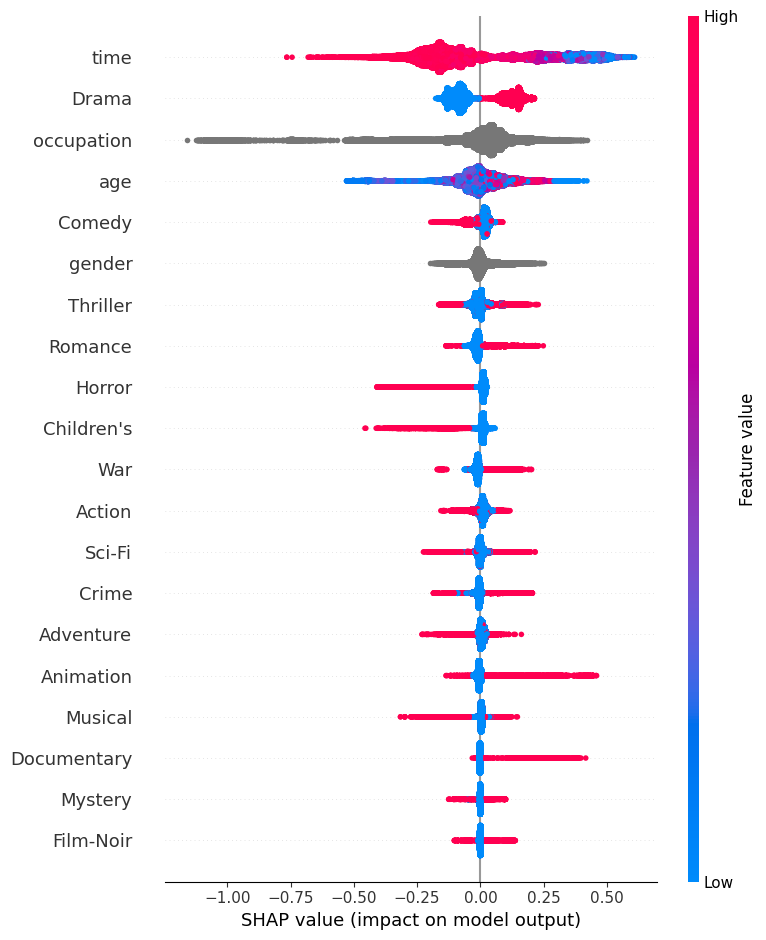

In [24]:
import matplotlib.pyplot as plt


fig = shap.summary_plot(shap_values, train_df, show=False)
plt.savefig("../reports/figures/importance_gb.png")

In [25]:
for feature, importance in zip(train_df.columns, gb.feature_importances_):
    print(feature, importance)

Action 2.491690407163333
Adventure 1.9187290664298793
Animation 2.019453971442984
Children's 1.9875062038132216
Comedy 2.2977102332872343
Crime 2.3849473043828313
Documentary 0.5027806874347037
Drama 7.041619769490422
Fantasy 0.18363734726567138
Film-Noir 0.4282777022588173
Horror 1.7830225559916926
Musical 1.0620923549076415
Mystery 0.38736097283332654
Romance 2.497416855567397
Sci-Fi 2.6213572836283956
Thriller 4.024848614525511
War 1.8707845048751846
Western 0.07812892192777243
age 19.12421412096608
gender 4.3230093609927644
occupation 18.25513901579691
time 22.716272745018216


# Conclusion

Classical ML approaches on the task of rating prediction significantly outperform random and "most popular 100" baselines. They also have a strong advantage of being robust to cold start on new users as no explicit similarity measure is estimated between users. For this very reason, models solving the task in such a setting fall short of CF methods which do utilize user's similarity for items recommendation.